# Cat & Dog Classifier

## 1. Imports

In [1]:
from keras import Sequential
import tensorflow as tf
from tensorflow import keras as k
import keras.layers as l 
from matplotlib import pyplot as plt
import random
import math
import os

## 2. Removing corrupted images

In [2]:
# for folder_name in ("Cat", "Dog"):
#     folder_path = os.path.join("../PetImages", folder_name)
#     for fname in os.listdir(folder_path):
#         fpath = os.path.join(folder_path, fname)
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
#         finally:
#             fobj.close()

#         if not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

## 3. Generating dataset

In [3]:
# Setting dataset
dataset = "../PetImages/small_ds"

# Images properties
image_size = (28, 28)
color_mode = 'rgb'

# Training properties
batch_size = 10
validation_split = 0.2

# Just a random seed
seed = random.randint(0, 10000)
print(f"Seed: {seed}")

# Defining train and validation datasets
train_dataset = k.preprocessing.image_dataset_from_directory(
    dataset,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    crop_to_aspect_ratio=True,  # Crop to squares to keep aspect ratio and avoid distortions
    batch_size=batch_size,
    color_mode=color_mode
)
validation_dataset = k.preprocessing.image_dataset_from_directory(
    dataset,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    color_mode=color_mode
)

Seed: 6931
Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


## 4. Improving dataset performance

In [4]:
# Prefetching the data to improve performance during training
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## 5. Data augmentation

In [5]:
# Flipping and rotating images to augment the dataset to improve  the robustness of the model
data_augmentation = Sequential([
    l.RandomFlip(),
    l.RandomRotation(factor=0.5),
])

## 6. Defining model

In [6]:
# Defining the model
model = Sequential()

# Input layer size, data augmentation and rescaling (to normalize the data)
model.add(k.Input(shape=image_size + (1 if color_mode=='grayscale' else 3,)))
model.add(data_augmentation)
model.add(l.Rescaling(1./255))

# Adding Convolutional layers with batch normalization for improving the robustness of the model
model.add(l.Conv2D(32, 3))
model.add(l.BatchNormalization())
model.add(l.Activation("relu"))

model.add(l.Conv2D(64, 3))
model.add(l.BatchNormalization())
model.add(l.Activation("relu"))

# Adding Max Pooling layer to reduce the size of the feature maps
model.add(l.MaxPooling2D())

# Adding Convolutional layers with batch normalization for improving the robustness of the model
model.add(l.Conv2D(64, 3))
model.add(l.BatchNormalization())
model.add(l.Activation("relu"))

# Flatten values to feed into the fully connected layer
model.add(l.Flatten())
model.add(l.Dense(units=32, activation='relu'))

# Dropout layer to reduce overfitting
model.add(l.Dropout(0.1))

# Output layer with sigmoid activation function to get probabilities for being a cat or dog
model.add(l.Dense(units=1, activation='sigmoid'))

# Print summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                      

## 7. Training the model

In [7]:
# Tune training hyperparameters
n_epochs = 200
# Learning rate decay schedule to reduce loss and improve accuracy
lr_schedule = k.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.9,
)

# Compile the model
model.compile(
    optimizer=k.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=n_epochs,
    validation_data=validation_dataset,
    workers=8
)

Epoch 1/200
16/16 [==============================] - 1s 34ms/step - loss: 0.9540 - accuracy: 0.5813 - val_loss: 0.7052 - val_accuracy: 0.5000
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 0.8799 - accuracy: 0.4938 - val_loss: 0.6954 - val_accuracy: 0.4500
Epoch 3/200
16/16 [==============================] - 0s 19ms/step - loss: 0.7497 - accuracy: 0.5875 - val_loss: 0.6961 - val_accuracy: 0.5250
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 0.6740 - accuracy: 0.5813 - val_loss: 0.6774 - val_accuracy: 0.6750
Epoch 5/200
16/16 [==============================] - 0s 19ms/step - loss: 0.6618 - accuracy: 0.5750 - val_loss: 0.6749 - val_accuracy: 0.5250
Epoch 6/200
16/16 [==============================] - 0s 19ms/step - loss: 0.6431 - accuracy: 0.6000 - val_loss: 0.6707 - val_accuracy: 0.6500
Epoch 7/200
16/16 [==============================] - 0s 18ms/step - loss: 0.6142 - accuracy: 0.6875 - val_loss: 0.6590 - val_accuracy: 0.6000
Epoch 

## 8. Visualizing model training

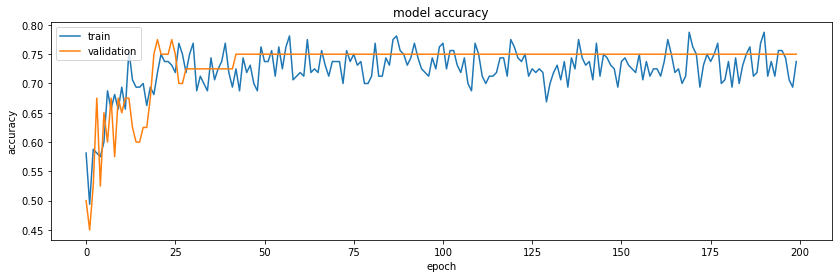

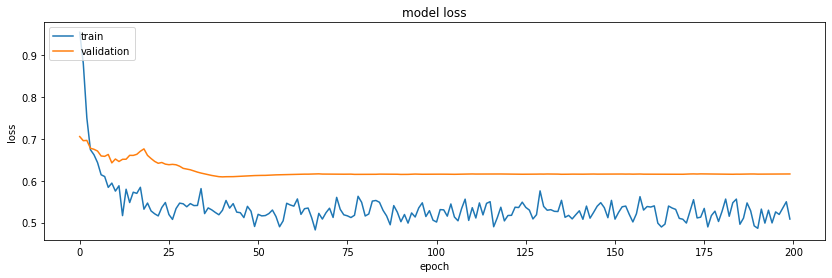

In [8]:
# Visualize the accuracy of the model
plt.figure(1, figsize=(14, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# Visualize the loss of the model
plt.figure(2, figsize=(14, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

## 9. Predicting

This image is [93.834015] % cat and [6.165987] % dog.


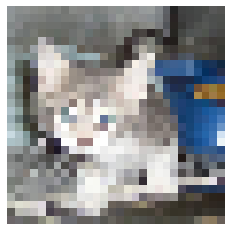

In [79]:
# Pick a random image from the unused dataset and predict its class
pred_dataset = "../PetImages/large_ds" if dataset == "../PetImages/small_ds" else "../PetImages/small_ds"
pred_dataset = os.path.join(pred_dataset, "cats")
images_paths = [im for im in os.listdir(pred_dataset) if im.endswith(".jpg")]
img = k.preprocessing.image.load_img(
    os.path.join(pred_dataset, random.choice(images_paths)),
    target_size=image_size,
    color_mode=color_mode
)

# Display the image
plt.axis('off')
plt.imshow(img)

# Convert the image to a tensor
img_array = k.preprocessing.image.img_to_array(img)

# Create batch axis to feed the image into the model
img_array = tf.expand_dims(img_array, 0)

# Predict the class of the image and print it
predictions = model.predict(img_array)
score = predictions[0]
print(f"This image is {100 * (1 - score)} % cat and {100 * score} % dog.")